In [114]:
import cv2
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/pneumonia-clasification/Dataset/Dataset/2/person1650_virus_2852.jpeg
/kaggle/input/pneumonia-clasification/Dataset/Dataset/2/person22_virus_55.jpeg
/kaggle/input/pneumonia-clasification/Dataset/Dataset/2/person79_virus_148.jpeg
/kaggle/input/pneumonia-clasification/Dataset/Dataset/2/person29_virus_64.jpeg
/kaggle/input/pneumonia-clasification/Dataset/Dataset/2/person75_virus_136.jpeg
/kaggle/input/pneumonia-clasification/Dataset/Dataset/2/person16_virus_47.jpeg
/kaggle/input/pneumonia-clasification/Dataset/Dataset/2/person23_virus_56.jpeg
/kaggle/input/pneumonia-clasification/Dataset/Dataset/2/person3_virus_17.jpeg
/kaggle/input/pneumonia-clasification/Dataset/Dataset/2/person1_virus_11.jpeg
/kaggle/input/pneumonia-clasification/Dataset/Dataset/2/person1650_virus_2854.jpeg
/kaggle/input/pneumonia-clasification/Dataset/Dataset/2/person21_virus_52.jpeg
/kaggle/input/pneumonia-clasification/Dataset/Dataset/2/person26_virus_60.jpeg
/kaggle/input/pneumonia-clasification/Datase

In [115]:
# Save the training data directory in a variable
XRay_Directory = '/kaggle/input/pneumonia-clasification/Dataset/Dataset/'

# Check the folders in the directory
os.listdir(XRay_Directory)

['2', '0', '3', '1']

In [116]:
# Create tensor images, normalize them and create a validation set
image_generator = ImageDataGenerator(rescale = 1./255, validation_split= 0.2)

In [117]:
# Create the training generator
train_generator = image_generator.flow_from_directory(batch_size = 40, directory= XRay_Directory, shuffle= True, target_size=(256,256), class_mode = 'categorical', subset="training")

Found 428 images belonging to 4 classes.


In [118]:
# Create the validation generator
validation_generator = image_generator.flow_from_directory(batch_size = 40, directory= XRay_Directory, shuffle= True, target_size=(256,256), class_mode = 'categorical', subset="validation")

Found 104 images belonging to 4 classes.


In [119]:
# Generate a batch with 40 images
train_images, train_labels = next(train_generator)
train_images.shape,train_labels.shape

((40, 256, 256, 3), (40, 4))

In [120]:
# Dictionary with the categories
label_names = {0 : 'Covid-19',
               1 : 'Normal' ,
               2: 'Viral Pneumonia',
               3 : 'Bacterial Pneumonia'}

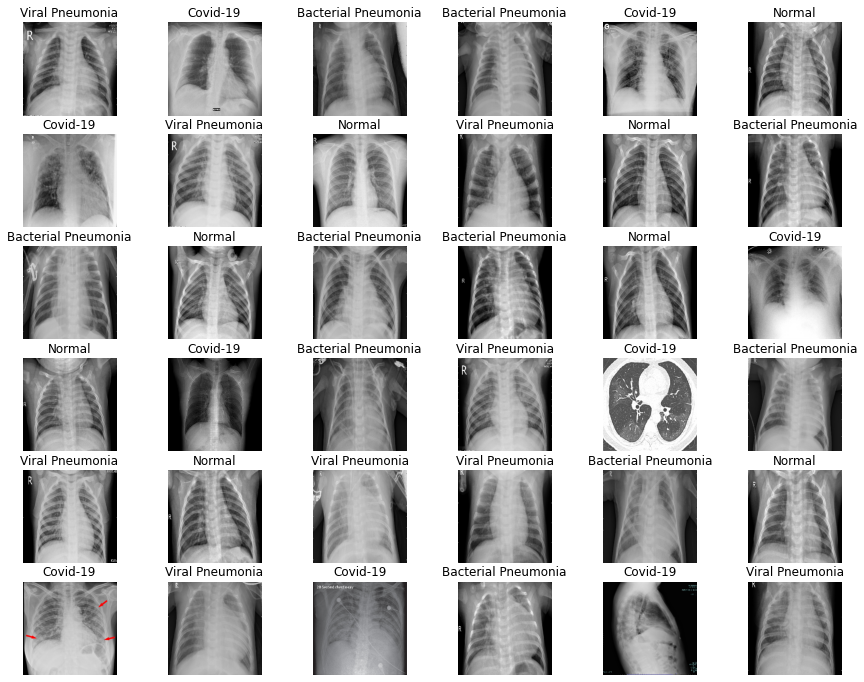

In [121]:
# Create a 6x6 matrix to show an example of the images
L = 6
W = 6

fig, axes = plt.subplots(L, W, figsize = (15, 12))
axes = axes.ravel()

for i in np.arange(0, L*W):
    axes[i].imshow(train_images[i])
    axes[i].set_title(label_names[np.argmax(train_labels[i])])
    axes[i].axis('off')

plt.subplots_adjust(wspace = 0.3)

In [122]:
# Using the ResNet50 imagenet weights for transfer learning
basemodel = ResNet50(weights = 'imagenet', include_top = False, input_tensor = Input(shape=(256,256,3)))
basemodel.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [123]:
# Freezing the model but not the last layers

for layer in basemodel.layers[:-10]:
  layers.trainable = False

In [124]:
# Create the last layers for our model
headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size = (4,4))(headmodel)
headmodel = Flatten(name= 'flatten')(headmodel)
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(128, activation = "relu")(headmodel)
headmodel = Dropout(0.2)(headmodel)
headmodel = Dense(4, activation = 'softmax')(headmodel)

model = Model(inputs = basemodel.input, outputs = headmodel)

In [125]:
model.compile(loss = 'categorical_crossentropy', optimizer=optimizers.RMSprop(learning_rate = 0.0001, decay = 0.000001), metrics= ["accuracy"])

In [126]:
# Using earlystopping to avoid overfitting
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

In [127]:
# Saving the best model weights
checkpoint = ModelCheckpoint(filepath="weights.hdf5", verbose=1, save_best_only=True)

In [128]:
train_generator = image_generator.flow_from_directory(batch_size = 4, directory= XRay_Directory, shuffle= True, target_size=(256,256), class_mode= 'categorical', subset="training")
val_generator = image_generator.flow_from_directory(batch_size = 4, directory= XRay_Directory, shuffle= True, target_size=(256,256), class_mode= 'categorical', subset="validation")

Found 428 images belonging to 4 classes.
Found 104 images belonging to 4 classes.


In [129]:
history = model.fit_generator(train_generator, steps_per_epoch= train_generator.n // 4, epochs = 25, validation_data= val_generator, validation_steps= val_generator.n // 4, callbacks=[checkpoint, earlystopping])

Epoch 1/25
107/107 [==============================] - 27s 137ms/step - loss: 0.8787 - accuracy: 0.6939 - val_loss: 14.9212 - val_accuracy: 0.4423

Epoch 00001: val_loss improved from inf to 14.92120, saving model to weights.hdf5
Epoch 2/25
107/107 [==============================] - 14s 134ms/step - loss: 0.5127 - accuracy: 0.8551 - val_loss: 30.2342 - val_accuracy: 0.2500

Epoch 00002: val_loss did not improve from 14.92120
Epoch 3/25
107/107 [==============================] - 13s 125ms/step - loss: 0.3535 - accuracy: 0.8785 - val_loss: 29.4579 - val_accuracy: 0.2500

Epoch 00003: val_loss did not improve from 14.92120
Epoch 4/25
107/107 [==============================] - 14s 126ms/step - loss: 0.2145 - accuracy: 0.9556 - val_loss: 45.7958 - val_accuracy: 0.2500

Epoch 00004: val_loss did not improve from 14.92120
Epoch 5/25
107/107 [==============================] - 14s 128ms/step - loss: 0.2147 - accuracy: 0.9509 - val_loss: 11.0594 - val_accuracy: 0.3173

Epoch 00005: val_loss impro

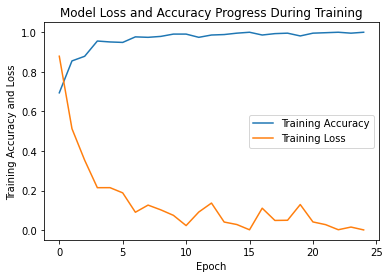

In [130]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])

plt.title('Model Loss and Accuracy Progress During Training')
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy and Loss')
plt.legend(['Training Accuracy', 'Training Loss'])
plt.show()

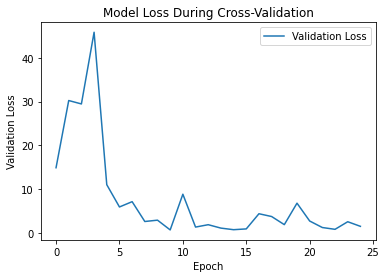

In [131]:
plt.plot(history.history['val_loss'])
plt.title('Model Loss During Cross-Validation')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend(['Validation Loss'])
plt.show()

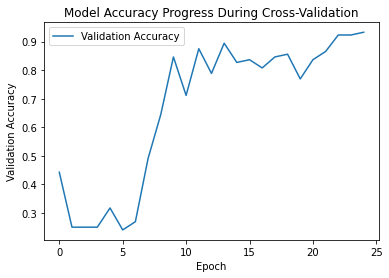

In [132]:
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy Progress During Cross-Validation')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.legend(['Validation Accuracy'])
plt.show()

In [133]:
test_directory = '/kaggle/input/pneumonia-clasification/Test/Test/'

In [140]:
test_gen = ImageDataGenerator(rescale = 1./255)

test_generator = test_gen.flow_from_directory(batch_size = 40, directory= test_directory, shuffle= True, target_size=(256,256), class_mode= 'categorical')

evaluate = model.evaluate_generator(test_generator, steps = test_generator.n // 4, verbose =1)

print('Accuracy Test : {}'.format(evaluate[1]))

Found 40 images belonging to 4 classes.
10/10 [==============================] - 1s 2ms/step - loss: 3.0312 - accuracy: 0.8000
Accuracy Test : 0.800000011920929


In [141]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

prediction = []
original = []
image = []

for i in range(len(os.listdir(test_directory))):
  for item in os.listdir(os.path.join(test_directory,str(i))):
    img= cv2.imread(os.path.join(test_directory,str(i),item))
    img = cv2.resize(img,(256,256))
    image.append(img)
    img = img / 255
    img = img.reshape(-1,256,256,3)
    predict = model.predict(img)
    predict = np.argmax(predict)
    prediction.append(predict)
    original.append(i)

In [142]:
score = accuracy_score(original,prediction)
print("Test Accuracy : {}".format(score))

Test Accuracy : 0.775


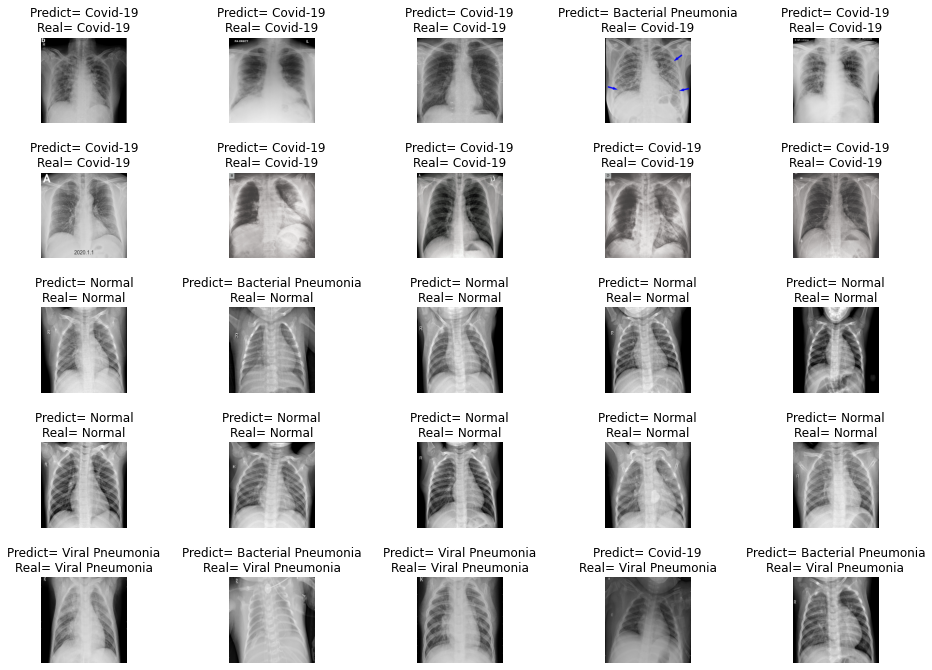

In [143]:
L = 5
W = 5

fig, axes = plt.subplots(L, W, figsize = (15, 12))
axes = axes.ravel()

for i in np.arange(0, L*W):
    axes[i].imshow(image[i])
    axes[i].set_title('Predict= {}\nReal= {}'.format(str(label_names[prediction[i]]), str(label_names[original[i]])))
    axes[i].axis('off')

plt.subplots_adjust(wspace = 1.2) 

In [144]:
print(classification_report(np.asarray(original), np.asarray(prediction)))

              precision    recall  f1-score   support

           0       0.90      0.90      0.90        10
           1       0.75      0.90      0.82        10
           2       1.00      0.50      0.67        10
           3       0.62      0.80      0.70        10

    accuracy                           0.78        40
   macro avg       0.82      0.77      0.77        40
weighted avg       0.82      0.78      0.77        40



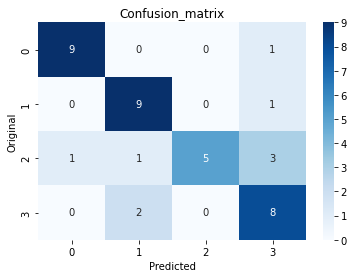

In [145]:
cm = confusion_matrix(np.asarray(original), np.asarray(prediction))
ax = plt.subplot()
sns.heatmap(cm, annot = True, ax = ax,cmap='Blues')

ax.set_xlabel('Predicted')
ax.set_ylabel('Original')
ax.set_title('Confusion_matrix')
plt.show()